# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. 

Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.
По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

Описание данных
- airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
- balcony — число балконов
- ceiling_height — высота потолков (м)
- cityCenters_nearest — расстояние до центра города (м)
- days_exposition — сколько дней было размещено объявление (от публикации до снятия)
- first_day_exposition — дата публикации
- floor — этаж
- floors_total — всего этажей в доме
- is_apartment — апартаменты (булев тип)
- kitchen_area — площадь кухни в квадратных метрах (м²)
- last_price — цена на момент снятия с публикации
- living_area — жилая площадь в квадратных метрах (м²)
- locality_name — название населённого пункта
- open_plan — свободная планировка (булев тип)
- parks_around3000 — число парков в радиусе 3 км
- parks_nearest — расстояние до ближайшего парка (м)
- ponds_around3000 — число водоёмов в радиусе 3 км
- ponds_nearest — расстояние до ближайшего водоёма (м)
- rooms — число комнат
- studio — квартира-студия (булев тип)
- total_area — площадь квартиры в квадратных метрах (м²)
- total_images — число фотографий квартиры в объявлении

---

# 1. Откроем данные, посмотрим на них

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import math

df = pd.read_csv('/datasets/visits.csv' ,  sep='\t')

df




,date_time,id,time_spent,name
0,20180406T165358,76144fb2,98.0,Василек
1,20180404T173913,76144fb2,15.0,Василек
2,20180403T172824,76144fb2,220.0,Василек
3,20180407T070441,76144fb2,19.0,Василек
4,20180404T132049,76144fb2,14.0,Василек
...,...,...,...,...
317099,20180408T053133,9cdb5039,11.0,Гейхера
317100,20180403T021353,9cdb5039,181.0,Гейхера
317101,20180408T062636,9cdb5039,252.0,Гейхера
317102,20180405T232425,9cdb5039,29.0,Гейхера


### Вывод

- 22 стобца очень много на самом деле
-повезло, явных дубликатов нет
-в названиях пропусков в слове поселок есть Ё и Е
- хм, много пропусков 
  думаю что-то не так с апаратаментами is_apartment (20 924) 
  опять же что-то не так с парками и водоемами, наверно пользватели хотят преукрасить свое жилье
- для balcony, floors_total, days_exposition нужно поменять значения, балконы, кол-во этожей и кол-во дней дожно быть целым

-Сначала обрабатываем те значения, которые легче логически заполнить is_apartment:

-Смотрим данные
-Смотрим количество пропущенных значений

-Заполняем пропуски значением "False" - оно самое логичное

-Проверяем, что пропуски заполнились


### Шаг 2. Предобработка данных

In [4]:
print (f"value_counts: \n{df['is_apartment'].value_counts()}")
print (f"\nisna count: \n{df['is_apartment'].isna().count()}")
df['is_apartment'] = df['is_apartment'].fillna(False)
print (f"\nvalue_counts: \n{df['is_apartment'].value_counts()}")

value_counts: 
False    2725
True       50
Name: is_apartment, dtype: int64

isna count: 
23699

value_counts: 
False    23649
True        50
Name: is_apartment, dtype: int64



- Смотрю данные

- Заполняю пропуски значением "0.0" - думаю оно подходит больше всего 

- Проверяем, что пропуски заполнились


In [5]:
print (f"value_counts: \n{df['balcony'].value_counts()}")
print (f"\nisna count: \n{df['balcony'].isna().sum()}")
df['balcony'] = df['balcony'].fillna(0.0)
print (f"\nvalue_counts: \n{df['balcony'].value_counts()}")
print (f"\nisna count: \n{df['balcony'].isna().sum()}")

value_counts: 
1.0    4195
0.0    3758
2.0    3659
5.0     304
4.0     183
3.0      81
Name: balcony, dtype: int64

isna count: 
11519

value_counts: 
0.0    15277
1.0     4195
2.0     3659
5.0      304
4.0      183
3.0       81
Name: balcony, dtype: int64

isna count: 
0


days_exposition:

- У некоторых квартир не заполен столбец "days_exposition" (сколько дней было размещено объявление), однако, у всех заполнен "last_price" - скорее всего, все квартиры были сняты с публикации, и пропуски в столбце "days_exposition" можно заполнить. Заполнение будет происходить в зависимости от даты публикации. Для каждого пропуска каждой даты будем высчитывать медианное значение заполненных дат.

- Перед заполнением пропусков в столбце "days_exposition" нужно перевести столбец "first_day_exposition" в дату, т.к. первый зависит от второго.

In [6]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

def get_median_days_exposition(df):
    #ф-ия заполнения количества дней размещения медианным значением
    years = pd.DatetimeIndex(df['first_day_exposition']).year.value_counts().index
    monthes = pd.DatetimeIndex(df['first_day_exposition']).month.value_counts().index

    for year in years:
        for month in monthes:
            median = df[(df['days_exposition'].notna()) & (pd.DatetimeIndex(df['first_day_exposition']).year == year) & (pd.DatetimeIndex(df['first_day_exposition']).month == month)]['days_exposition'].median()
            if math.isnan(median):
                median = df[(df['days_exposition'].notna()) & (pd.DatetimeIndex(df['first_day_exposition']).year == year)]['days_exposition'].median()
            df.loc[((df['days_exposition'].isna()) & (pd.DatetimeIndex(df['first_day_exposition']).year == year) & (pd.DatetimeIndex(df['first_day_exposition']).month == month)), 'days_exposition'] = median
            
    return df

print ("Заполняем пропуски в столбце \"days_exposition\"\nВсего пропусков: ")
print (df['days_exposition'].isna().sum())
df = get_median_days_exposition(df)

print ("\nПроверяем, что пропуски заполнились: ")
print (df['days_exposition'].isna().sum())

Заполняем пропуски в столбце "days_exposition"
Всего пропусков: 
3181

Проверяем, что пропуски заполнились: 
0



living_area:

- Проверяем количество пропусков

- Ищем зависимости между общей площадью и жилой

- Заполняем пропуски

- Проверяем, что пропуски заполнились

In [7]:
print (f"isna sum: {df['living_area'].isna().sum()}")
print ("\nИщем зависимости между общей площадью и другими параметрами:")
#print (df[df['living_area'].notna()]['living_area'].corr(df[df['total_area'].notna()]['total_area']))
#print (df[df['living_area'].notna()]['living_area'].corr(df[df['rooms'].notna()]['rooms']))
       
print (df.corr()['living_area'].reset_index(name='correlation'))

isna sum: 1903

Ищем зависимости между общей площадью и другими параметрами:
                  index  correlation
0          total_images     0.104780
1            last_price     0.566492
2            total_area     0.939537
3                 rooms     0.845977
4        ceiling_height     0.090650
5          floors_total    -0.169311
6           living_area     1.000000
7                 floor    -0.097210
8          is_apartment     0.026969
9                studio    -0.056231
10            open_plan    -0.033711
11         kitchen_area     0.428674
12              balcony    -0.014772
13     airports_nearest    -0.057912
14  cityCenters_nearest    -0.231368
15     parks_around3000     0.184453
16        parks_nearest    -0.050167
17     ponds_around3000     0.148933
18        ponds_nearest    -0.081674
19      days_exposition     0.115915


- Обнаружена прямая зависимость между жилой площадью и общей площадью: коэффициент корреляции 0.93

- Обнаружена прямая зависимость между жилой площадью и количеством комнат: коэффициент корреляции 0.84

- Обнаружена прямая зависимость между жилой площадью и ценой квартиры: коэффициент корреляции 0.56

Первые два параметра достаточно сильные, пропуски можно заполнить, опираясь только на них.
Заполним пропуски: сначала по общей площади, после по жилой:

In [8]:
def get_median_living_area(df):
    #ф-ия заполнения пропусков в жилой площади медианным значением"""
    areas = df['total_area'].value_counts().index
    for area in areas:
        median = df[((df['living_area'].notna()) & (df['total_area'] == area))]['living_area'].median()
        df.loc[((df['living_area'].isna()) & (df['total_area'] == area)), 'living_area'] = median
    
    rooms = df['rooms'].value_counts().index
    for room in rooms:
        median = df[((df['living_area'].notna()) & (df['rooms'] == room))]['living_area'].median()
        df.loc[((df['living_area'].isna()) & (df['rooms'] == room)), 'living_area'] = median
    
    return df

df = get_median_living_area(df)
print ("\nПроверяем, что пропуски заполнились ")
print (f"isna sum: {df['living_area'].isna().sum()}")


Проверяем, что пропуски заполнились 
isna sum: 0



Теперь на основе жилой площади можно заполнить площадь кухни. Делим всю жилую площадь на 10 квантилей, ищем медианное значение и заполняем пропуски

kitchen_area:

- Проверяем количество пропусков

- Заполняем пропуски

- Проверяем, что пропуски заполнились


In [9]:
print (f"isna sum: {df['kitchen_area'].isna().sum()}")

def get_median_kitchen_area(df):
    df.sort_values(by='living_area', inplace=True)
    df['quantile_areas'] = pd.qcut(df['living_area'], 10, labels=False)
    areas = df['quantile_areas'].value_counts().index
    for area in areas:
        median = df[(df['kitchen_area'].notna()) & (df['quantile_areas'] == area)]['kitchen_area'].median()
        df.loc[(df['kitchen_area'].isna()) & (df['quantile_areas'] == area), 'kitchen_area'] = median
    
    return df

print ("Заполняем пропуски в столбце \"days_exposition\"\nВсего пропусков: ")
print (df['days_exposition'].isna().sum())
       
df = get_median_kitchen_area(df)
print ("\nПроверяем, что пропуски заполнились: ")
print (f"isna sum: {df['kitchen_area'].isna().sum()}")

isna sum: 2278
Заполняем пропуски в столбце "days_exposition"
Всего пропусков: 
0

Проверяем, что пропуски заполнились: 
isna sum: 0


-Смотрим, сколько всего этажей в домах. На первый взгляд этажей много, как проследить зависимость от других параметров я не млшу сказаьб точно. 
-Обычно, количество этажей дома не зависит от чего-либо. В одном доме могут быть разные квартиры - однушки, трешки, разной площади и с разными балконами.

- floors_total:

- Смотрим, сколько всего этажей в домах

- Заполняем пропуски средней температурой по больнице

- Проверяем, что пропуски заполнились

In [10]:
print (f"isna sum: {df['floors_total'].isna().sum()}")
print (df[df['floors_total'].notna()]['floors_total'].value_counts())
floors_total_mean = df[df['floors_total'].notna()]['floors_total'].mean()
df['floors_total'] = df.fillna(floors_total_mean)
df['floors_total'] = df['floors_total'].astype(int)
print ("\nПроверяем, что пропуски заполнились: ")
print (f"isna sum: {df['floors_total'].isna().sum()}")

isna sum: 86
5.0     5788
9.0     3761
16.0    1376
12.0    1362
4.0     1200
10.0    1174
25.0    1075
6.0      914
17.0     833
3.0      668
7.0      592
14.0     553
18.0     505
24.0     469
8.0      390
2.0      383
15.0     365
23.0     352
19.0     339
22.0     286
20.0     271
13.0     229
11.0     203
27.0     164
21.0     158
26.0     124
1.0       25
35.0      24
28.0      21
36.0       3
29.0       1
52.0       1
33.0       1
60.0       1
37.0       1
34.0       1
Name: floors_total, dtype: int64

Проверяем, что пропуски заполнились: 
isna sum: 0


- Высота потолков не зависит от этажности дома или от площади. 

- Она напрямую зависит от класса. Если дом высокого класса и комфорта, то потолки будут высокие. 

- Если же стандартный класс - то потолки будут стандартно 2.67 - 2.72. 

- Попробуем привязаться к цене дома. Посмотрим, насколько потолок зависит от цены:

In [11]:
print (df[df['ceiling_height'].notna()]['ceiling_height'].corr(df[df['ceiling_height'].notna()]['last_price']))

0.08543030982842599


- Как видно, коэффициент корреляции стремится к нулю, следовательно, эти величины практически не связаны.

- Посмотрим среднюю высоту потолков по всем домам в выборке:

In [12]:
print (f"Средняя: {df[df['ceiling_height'].notna()]['ceiling_height'].mean().round(2)}")
print (f"Медианная: {df[df['ceiling_height'].notna()]['ceiling_height'].median()}")

Средняя: 2.77
Медианная: 2.65


Средний показатель что-то слишком высокий. Запоним пропуски медианным:

In [13]:
print (f"isna sum: {df['ceiling_height'].isna().sum()}")
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median())
print ("\nПроверяем, что пропуски заполнились: ")
print (f"isna sum: {df['ceiling_height'].isna().sum()}")

isna sum: 9195

Проверяем, что пропуски заполнились: 
isna sum: 0


Оставшиеся пропуски - данные о местоположении, парках и водоемах поблизости. Эти значения не зависят от других величин. Добавим информацию о том, что для них значение не опредлено.

In [14]:
df['locality_name'] = df['locality_name'].fillna('undefined')
df['airports_nearest'] = df['airports_nearest'].fillna(-999.99)
df['cityCenters_nearest'] = df['cityCenters_nearest'].fillna(-999.99)
df['parks_around3000'] = df['parks_around3000'].fillna(-999.99)
df['parks_nearest'] = df['parks_nearest'].fillna(-999.99)
df['ponds_nearest'] = df['ponds_nearest'].fillna(-999.99)

print ("\nЗаменяем поле last_price на тип int")
df['last_pice'] = df['last_price'].astype(int)
df.loc[df['last_pice'] <= 0, 'last_pice'] = df['last_price'].median().astype(int)

print ("\nЗаодно почистим значения в единственном строковом столбце")       
df['locality_name'] = df['locality_name'].str.strip().str.lower()

print ("\nПроверяем, что все данные заполнились:")
print (df.info())


Заменяем поле last_price на тип int

Заодно почистим значения в единственном строковом столбце

Проверяем, что все данные заполнились:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23699 entries, 21758 to 19540
Data columns (total 24 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23699 non-null int64
living_area             23699 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            23699 non-null float64
balcony                 23699 non-null float64
locality_name           23699 non-null object
airports_nearest        23699 non-null float64
cityCenter

### Шаг 3. Посчитайте и добавьте в таблицу

In [15]:
print ("\nРассчитываем цену квадратного метра: last_price / total_area")
df['square_meter_price'] = df['last_price'] / df['total_area']
print ("\nРассчитываем день недели, месяц и год публикации объявления")
df['day_exposition'] = pd.DatetimeIndex(df['first_day_exposition']).weekday
df['month_exposition'] = pd.DatetimeIndex(df['first_day_exposition']).month
df['year_exposition'] = pd.DatetimeIndex(df['first_day_exposition']).year
print ("\nРассчитываем этаж квартиры: Первый, последний, другой")

def get_flat_floor (rows):
    floor = rows[0]
    floors_total = rows[1]
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    return 'другой'

df['floor_kind'] = df[['floor', 'floors_total']].apply(get_flat_floor, axis=1)
print ("\nПроверяем, что данные заполнились: ")
print (df['floor_kind'].value_counts())
print ("\nРасчитываем соотношение жилой площади к общей.")
df['living_to_total_area'] = df['living_area'] / df['total_area']
print ("\nРасчитываем соотношение площади кухни к общей площади.")
df['living_to_total_area'] = df['kitchen_area'] / df['total_area']


Рассчитываем цену квадратного метра: last_price / total_area

Рассчитываем день недели, месяц и год публикации объявления

Рассчитываем этаж квартиры: Первый, последний, другой

Проверяем, что данные заполнились: 
другой       19883
первый        2917
последний      899
Name: floor_kind, dtype: int64

Расчитываем соотношение жилой площади к общей.

Расчитываем соотношение площади кухни к общей площади.


### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

AxesSubplot(0.125,0.125;0.775x0.755)


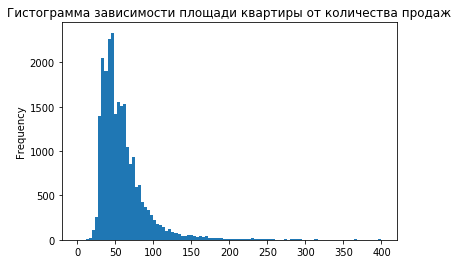

AxesSubplot(0.125,0.125;0.775x0.755)


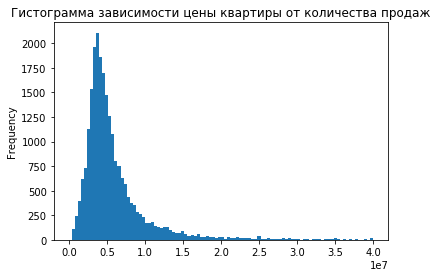

AxesSubplot(0.125,0.125;0.775x0.755)


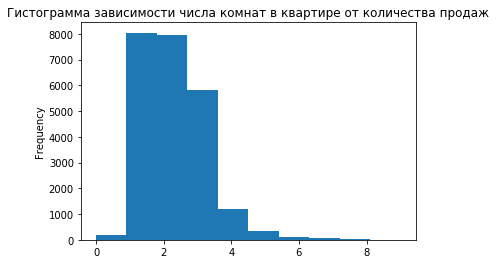

AxesSubplot(0.125,0.125;0.775x0.755)


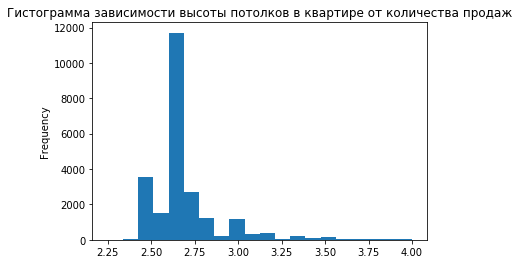

In [16]:
def print_hist_plots(df, columns, bins, ranges, ylims, titles):
    #печать гистограмм с заданными параметрами
    for i in range(0, len(columns)):
        print (df[columns[i]].plot(
            kind='hist', 
            bins=bins[i], 
            range=ranges[i],
            ylim=ylims[i],
            title=titles[i]
        ))
        plt.show()
    return

print_hist_plots(
    df, 
    ['total_area', 'last_price', 'rooms', 'ceiling_height'],
    [100, 100, 10, 20],
    [(0, 400), (0, 40000000), (0, 9), (2.25, 4)],
    [None, None, None, None],
    [
        'Гистограмма зависимости площади квартиры от количества продаж',
        'Гистограмма зависимости цены квартиры от количества продаж',
        'Гистограмма зависимости числа комнат в квартире от количества продаж',
        'Гистограмма зависимости высоты потолков в квартире от количества продаж',
    ]
)

Проверяем время продажи квартиры

AxesSubplot(0.125,0.125;0.775x0.755)


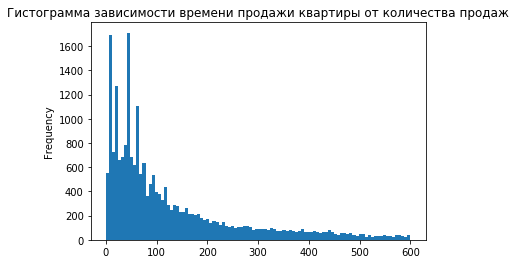

In [29]:
print_hist_plots(
    df, 
    ['days_exposition'],
    [100],
    [(0, 600)],
    [None],
    [
        'Гистограмма зависимости времени продажи квартиры от количества продаж',
    ]
)

- Обычно квартира либо продается сразу, либо в течении 3-х месяцев (90 дней). На гистограмме видно, что после 90-100 дней идет спад количества проданных квартир. "Хвост" тянется очень далеко, примерно на 600 днях его можно обрубить - дальше нет смысла рассматривать значения

- Убираем хвосты и выбивающиеся значения у диаграмм выше

AxesSubplot(0.125,0.125;0.775x0.755)


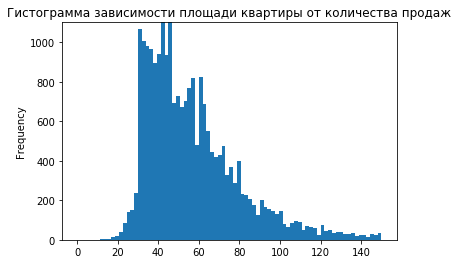

AxesSubplot(0.125,0.125;0.775x0.755)


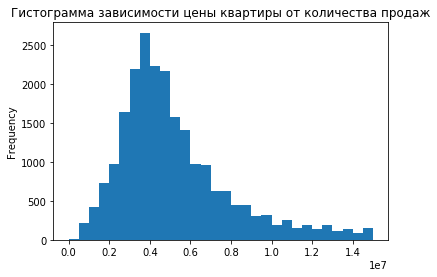

AxesSubplot(0.125,0.125;0.775x0.755)


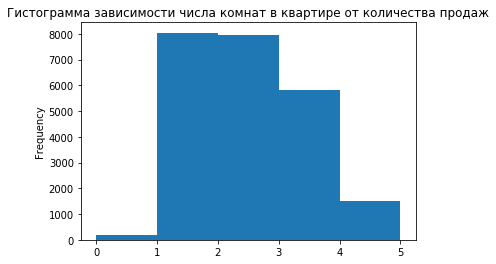

AxesSubplot(0.125,0.125;0.775x0.755)


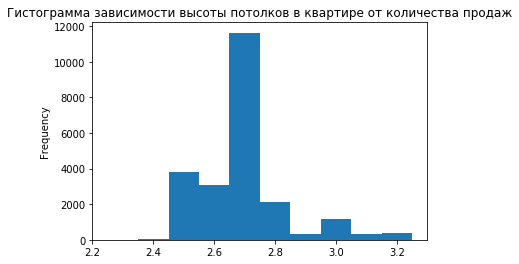

AxesSubplot(0.125,0.125;0.775x0.755)


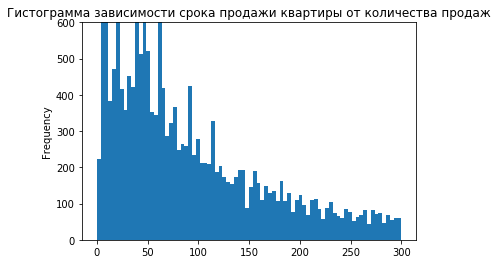

In [18]:
print_hist_plots(
    df, 
    ['total_area', 'last_price', 'rooms', 'ceiling_height', 'days_exposition'],
    [80, 30, 5, 10, 80],
    [(0, 150), (0, 15000000), (0, 5), (2.25, 3.25), (0, 300)],
    [(0, 1100), None, None, None, (0, 600)],
    [
        'Гистограмма зависимости площади квартиры от количества продаж',
        'Гистограмма зависимости цены квартиры от количества продаж',
        'Гистограмма зависимости числа комнат в квартире от количества продаж',
        'Гистограмма зависимости высоты потолков в квартире от количества продаж',
        'Гистограмма зависимости срока продажи квартиры от количества продаж'
    ]
)

<font color=green> Да, теперь автоматизация появилась. Здорово, что она используется во всех пунктах работы.
    
---

На гистограммах выше обнаружены следующие зависимости:

- Лучше всего продаются квартиры с площадью от 35 до 60 м^2

- Больше всего квартир с ценой от 2.5 до 7 миллионов.

- Больше всего пользуются спросом 1,2 и 3-х комнатные квартриры. Реже 4-х.

- Самая популярная высота потолков 2.5 - 2.8. Наши предположения подтвердились.

- Большинство квартир продается довольно быстро. от 0 до 100-150 дней.

Изучаем, какие факторы влияют на стоимость квартиры:

In [19]:
print ("Зависимость цены от квадратного метра: ")
print (df['last_price'].corr(df['square_meter_price']))
print ("Зависимость цены от этажа: ")
df['floor_kind_category'] = df['floor_kind'].astype('category').cat.codes
print (df['last_price'].corr(df['floor_kind_category']))
print ("Зависимость цены от количества комнат: ")
print (df['last_price'].corr(df['rooms']))
print ("Зависимость цены от удаленности от цента: ")
print (df['last_price'].corr(df[df['cityCenters_nearest'] != -999.99]['cityCenters_nearest']))
print ("Зависимость цены от дня публикации: ")
print (df['last_price'].corr(df['day_exposition']))
print ("Зависимость цены от месяца публикации: ")
print (df['last_price'].corr(df['month_exposition']))
print ("Зависимость цены от года публикации: ")
print (df['last_price'].corr(df['year_exposition']))

Зависимость цены от квадратного метра: 
0.7364988054723014
Зависимость цены от этажа: 
-0.0456290865872808
Зависимость цены от количества комнат: 
0.36334284996489546
Зависимость цены от удаленности от цента: 
-0.20674734874298373
Зависимость цены от дня публикации: 
0.0015501452176215444
Зависимость цены от месяца публикации: 
0.0027791287507397235
Зависимость цены от года публикации: 
-0.04308903619950858


- Цена квартиры напрямую зависит от цены квадратного метра. Так же прослеживается зависимость от количества комнат.

- От остальных вышерпдеставленных параметров цена не зависит - коэффициент корреляции меньше 0.1 и стремится к нулю.

- 10 населенных пунктов с наибольшим числом объявлений:

In [20]:
top_ads = df.groupby('locality_name')['last_price'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(10)
top_ads

,locality_name,count
346,санкт-петербург,15721
297,посёлок мурино,522
336,посёлок шушары,440
4,всеволожск,398
340,пушкин,369
134,колпино,338
302,посёлок парголово,327
7,гатчина,307
58,деревня кудрово,299
5,выборг,237


In [21]:
#cредняя цена за метр в этих районах
def get_mean_square_price(row):
    return df[df['locality_name'] == row]['square_meter_price'].median().astype(int)

top_ads['mean_square_price'] = top_ads['locality_name'].apply(get_mean_square_price)
top_ads

,locality_name,count,mean_square_price
346,санкт-петербург,15721,104761
297,посёлок мурино,522,85878
336,посёлок шушары,440,76876
4,всеволожск,398,65789
340,пушкин,369,100000
134,колпино,338,74723
302,посёлок парголово,327,91642
7,гатчина,307,67796
58,деревня кудрово,299,91860
5,выборг,237,58158


In [22]:
print (f"Самая высокая стоимость жилья в населенном пункте \"{top_ads.sort_values(by='mean_square_price', ascending=False).head(1)['locality_name'].to_string(index=False)}\"")
print (f"Самая низкая стоимость жилья в населенном пункте \"{top_ads.sort_values(by='mean_square_price').head(1)['locality_name'].to_string(index=False)}\"")

Самая высокая стоимость жилья в населенном пункте " санкт-петербург"
Самая низкая стоимость жилья в населенном пункте " выборг"


- Ищем центр Санкт-Петербурга

- Отфильтруем данные по местоположению "Санкт-Петербург":

In [23]:
#Округляем расстояние до центра
spb_data = df[(df['locality_name'] == 'санкт-петербург') & (df['cityCenters_nearest'] != -999.99)]
spb_data.reset_index(drop=True, inplace=True)

In [24]:
#Считаем среднюю цену для каждого километра:
def get_mean_per_m(row):
    return spb_data[spb_data['cityCenters_nearest'] == row]['last_price'].median().astype(int)

meters = spb_data['cityCenters_nearest'].value_counts().index
df_meters = pd.DataFrame({'meters': meters})
df_meters['city_price_mean'] = df_meters['meters'].apply(get_mean_per_m)
df_meters['city_price_mean'].head()

0    10800000
1     7018751
2    11225000
3     6500000
4    11472552
Name: city_price_mean, dtype: int64

- Решил использовать метры, так более точнее

- Построим график, чтобы понять где сильно мемняется цена - ищем центр с города с мажорскими ценами

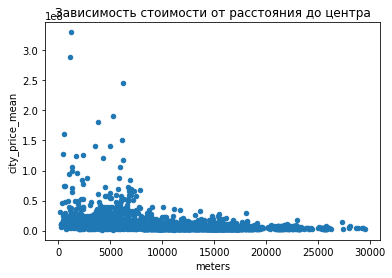

In [25]:
df_meters.plot(
    kind='scatter',
    x='meters',
    y='city_price_mean',
    title='Зависимость стоимости от расстояния до центра'
)

- График резко меняется на значении x=7500. Значит, в центр входят все квартиры, у которых расстояне до центра меньше, чем 7500


### Изучаем зависимости квартир в центральном районе

In [26]:
spb_center = spb_data[spb_data['cityCenters_nearest'] < 7500]
spb_center.reset_index(drop=True, inplace=True)

def get_median(df, columns, names):
    print ("\n")
    for i in range(0, len(columns)):
        print (f"Медиана {names[i]}: {df[columns[i]].median().round(3)}")
    return 

print ("\nЦентр Санкт-Петербурга:")
print (spb_center.corr()['last_price'].reset_index(name='correlation'))
get_median(
    spb_center,
    [
        'last_price',
        'ceiling_height',
        'living_area',
        'kitchen_area',
        'rooms',
    ],
    [
        'цены квартиры',
        'высоты потолков',
        'жилой площади',
        'площади кухни',
        'количества комнат',
    ]
)

print ("\n\nВесь город: ")
print (spb_data.corr()['last_price'].reset_index(name='correlation'))
get_median(
    spb_data,
    [
        'last_price',
        'ceiling_height',
        'living_area',
        'kitchen_area',
        'rooms',
    ],
    [
        'цены квартиры',
        'высоты потолков',
        'жилой площади',
        'площади кухни',
        'количества комнат',
    ]
)


Центр Санкт-Петербурга:
                   index  correlation
0           total_images     0.139547
1             last_price     1.000000
2             total_area     0.613480
3                  rooms     0.314874
4         ceiling_height     0.070556
5           floors_total     0.139547
6            living_area     0.515818
7                  floor     0.108597
8           is_apartment     0.038371
9                 studio    -0.024421
10             open_plan     0.011275
11          kitchen_area     0.395588
12               balcony     0.072374
13      airports_nearest     0.079389
14   cityCenters_nearest    -0.042186
15      parks_around3000     0.118542
16         parks_nearest     0.037660
17      ponds_around3000     0.101565
18         ponds_nearest     0.025402
19       days_exposition     0.052421
20        quantile_areas     0.263086
21             last_pice     1.000000
22    square_meter_price     0.796470
23        day_exposition     0.028284
24      month_exposition 

- Как видим, общие показатели зависимости параметров практически не отличаются. Переведем выше полученные показатели в удобочитаемую таблицу:

In [27]:
names = [
    'Зависимость цены от квадратного метра', 
    'Зависимость цены от этажа', 
    'Зависимость цены от количества комнат', 
    'Зависимость цены от удаленности от цента',
    'Зависимость цены от высоты потолков',
    'Зависимость цены от дня публикации',
    'Зависимость цены от месяца публикации',
    'Зависимость цены от года публикации',
    'Медиана цены квартиры',
    'Медиана высоты потолков',
    'Медиана жилой площади',
    'Медиана площади кухни',
    'Медиана количества комнат',
]

city_total_spb = { 
    'spb_total': [0.76, -0.03, 0.37, -0.25, 0.06, 0.00, 0.00, -0.04, 5500000.0, 2.65, 31.2, 9.7, 2.0],
    'spb_center': [0.79, -0.06, 0.31, -0.04, 0.07, 0.02, -0.01, -0.04, 9200000.0, 2.8, 46.0, 11.9, 3.0]
}

compare_df = pd.DataFrame(city_total_spb, index=names)
compare_df['difference'] = (compare_df['spb_total'] - compare_df['spb_center']).round(2)
compare_df

,spb_total,spb_center,difference
Зависимость цены от квадратного метра,0.76,0.79,-0.03
Зависимость цены от этажа,-0.03,-0.06,0.03
Зависимость цены от количества комнат,0.37,0.31,0.06
Зависимость цены от удаленности от цента,-0.25,-0.04,-0.21
Зависимость цены от высоты потолков,0.06,0.07,-0.01
Зависимость цены от дня публикации,0.00,0.02,-0.02
Зависимость цены от месяца публикации,0.00,-0.01,0.01
Зависимость цены от года публикации,-0.04,-0.04,0.00
Медиана цены квартиры,5500000.00,9200000.00,-3700000.00
Медиана высоты потолков,2.65,2.80,-0.15


AxesSubplot(0.125,0.125;0.775x0.755)


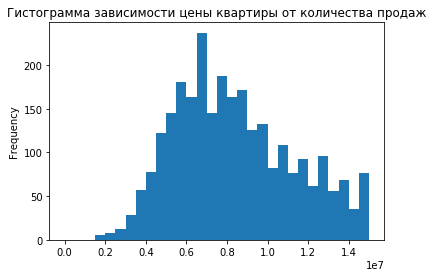

AxesSubplot(0.125,0.125;0.775x0.755)


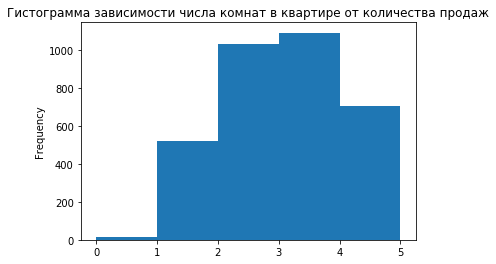

AxesSubplot(0.125,0.125;0.775x0.755)


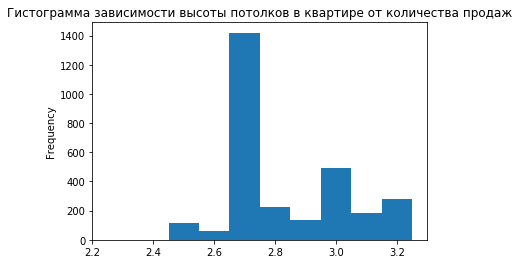

AxesSubplot(0.125,0.125;0.775x0.755)


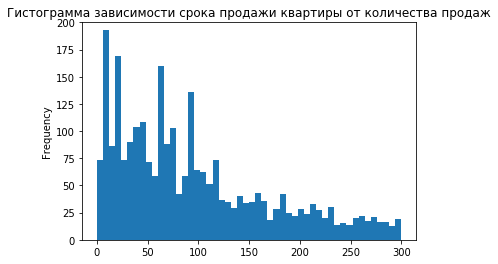

In [28]:
print_hist_plots(
    spb_center, 
    ['last_price', 'rooms', 'ceiling_height', 'days_exposition'],
    [30, 5, 10, 50],
    [(0, 15000000), (0, 5), (2.25, 3.25), (0, 300)],
    [None, None, None, (0, 200)],
    [
        'Гистограмма зависимости цены квартиры от количества продаж',
        'Гистограмма зависимости числа комнат в квартире от количества продаж',
        'Гистограмма зависимости высоты потолков в квартире от количества продаж',
        'Гистограмма зависимости срока продажи квартиры от количества продаж'
    ]
)

### Шаг 5. Общий вывод

Недвижимость в центре Петербурга ожидаемо стоит дороже остальных населенных пунктов.
Ближе к центру города дороже. Однако в пределах центра стоимость +/- однинаковая.
Факторы, влияющие на стоимость:
общая площадь
кол-во комнат
высота потолков

На стоимость квартиры прямо и очень сильно влияют:

Цена квадратного метра
Расположение квартиры
Количество комнат
В центре Санкт-Петербурга квартиры неоправданно дорогие. Интересное наблюдение, квартиры в таких домах, обычно, имеют высокие потолки, большую жилую площадь, большую кухню и не менее 3-х комнат. Так же, согласно последним графикам, квартиры в центре довольно быстро продаются.
Определены параметры, которые прямо влияют на стоимость квартиры:

Расположение квартиры (город/пригород, центр/не центр)
Количетво комнат
Жилай площадь
Количество комнат
Второстепенные данные, такие как "высота потолков, дата публикации" оказывают незначительное влияние на ценообразование.

### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод info())
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения
- [x]  есть пояснение какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение в каких столбцах изменены типы и почему
- [x]  посчитано и добавлено в таблицу: цена квадратного метра
- [x]  посчитано и добавлено в таблицу: день недели, месяц и год публикации объявления
- [x]  посчитано и добавлено в таблицу: этаж квартиры; варианты — первый, последний, другой
- [x]  посчитано и добавлено в таблицу: соотношение жилой и общей площади, а также отношение площади кухни к общей
- [x]  изучены следующие параметры: площадь, цена, число комнат, высота потолков
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"
- [x]  выполнено задание: "Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили."
- [x]  выполнено задание: "Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. "Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце '*locality_name'*. "
- [x]  выполнено задание: "Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (*'locality_name'*). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона. "
- [x]  выполнено задание: "Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"
- [x]  в каждом этапе есть выводы
- [x]  есть общий вывод